In [37]:
#!/usr/bin/env python
# ------------------------------------------------------------------------------
# Python 3 example on how to query by position the ESO SSA service
# and retrieve the spectra science files with SNR higher than a given threshold.
#
# Name: eso_ssa.py
# Version: 2018-04-09
# 
# In case of questions, please send an email to: usd-help@eso.org 
# with the following subject: ASG programmatic access (eso_ssa.py)
#
# Useful to read: http://www.astropy.org/astropy-tutorials/Coordinates.html
# ------------------------------------------------------------------------------

import sys

import pyvo as vo
from astropy.coordinates import SkyCoord
from astropy.units import Quantity

# --------------------------------------------------
# Define the end point and the SSA service to query:
# --------------------------------------------------

ssap_endpoint = "http://archive.eso.org/ssap"

ssap_service = vo.dal.SSAService(ssap_endpoint)

# A typical SSA invocation: ssap_endpoint + '?' + 'REQUEST=queryData&POS=197.44888,-23.38333&SIZE=0.5'
# where
#   197.44888 is the right ascension J2000 (decimal degrees),
#   -23.38333 is the declination J2000 (decimal degrees),
#   0.5       is the diameter of the cone to search in (decimal degrees).
# Within astroquery this is achieved by the following lines:
#   mytarget = SkyCoord(197.44888, -23.38333, unit='deg')
#   mysize   = Quantity(0.5, unit="deg")
#   ssap_resultset = ssap_service.search(pos=mytarget, diameter=mysize)
# Really the coordinates are ICRS, but for all practical effects when searching, there is no difference with J2000.


# --------------------------------------------------
# Prepare search parameters
# searching by cone around NGC 4993,
# with a diameter or 0.5 deg (radius=0.25 deg).
# --------------------------------------------------
target = "V1324 Sco"
diameter = 0.001

print()
print("Looking for spectra around target %s in a cone of diameter %f deg."   %(target, diameter))
print("Querying the ESO SSAP service at %s" %(ssap_endpoint))

# --------------------------------------------------
# The actual position of the selected target
# is queried by the from_name() function,
# which queries the CDS SESAME service
# (http://cdsweb.u-strasbg.fr/cgi-bin/Sesame).
# --------------------------------------------------

print("The provided target is being resolved by SESAME...")
pos = SkyCoord.from_name(target)
size = Quantity(diameter, unit="deg")
print("SESAME coordinates for %s: %s" % (target, pos.to_string()))

# see: http://docs.astropy.org/en/stable/coordinates/skycoord.html
# In case you know better the coordinates, then use:
# my_icrs_pos = SkyCoord(197.44888, -23.38333, unit='deg')    
#
# Or in case you know the galactic coordinates instead:
# my_gal_pos=SkyCoord(308.37745107, 39.29423547, frame='galactic', unit='deg')
#    in which case you will have to use:
# ssap_service.search(pos=my_gal_pos.fk5, diameter=size)
#    given that my_fk5_pos = my_gal_pos.fk5

# --------------------------------------------------
# Query in that defined cone (pos, size):
# --------------------------------------------------
print("Performing a Simple Spectral Access query...")
ssap_resultset = ssap_service.search(pos=pos.fk5, diameter=size)

# NOTE: The ESO coordinate system is: FK5. You would not be off by more than 20mas by querying by pos==pos.icrs (or simply pos=pos) instead.

# --------------------------------------------------
# define the output fields you are interested in;
# uppercase fields are the one defined by the SSAP standard as valid input fields
# --------------------------------------------------
fields = ["COLLECTION", "TARGETNAME", "s_ra", "s_dec", "APERTURE",
          "em_min", "em_max", "SPECRP", "SNR", "t_min", "t_max",
          "CREATORDID", "access_url"]



Looking for spectra around target V1324 Sco in a cone of diameter 0.001000 deg.
Querying the ESO SSAP service at http://archive.eso.org/ssap
The provided target is being resolved by SESAME...
SESAME coordinates for V1324 Sco: 267.725 -32.6225
Performing a Simple Spectral Access query...


In [ ]:


# for row in ssap_resultset:
#     print(row)

(13440, 'https://dataportal.eso.org/dataPortal/file/ADP.2020-06-09T06:35:43.457', 1.008, 'UVES', 'archival', 'ivo://eso.org/origfile?UV_SOBF_657725_2012-06-04T01:18:44.152_RED760d2_1x1_10.fits', '', 'http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2020-06-09T06:35:43.457', 185847, 'TOO_BulgeDwarf_657725_2012-06-04T01:18:44.152_RED760d2_1x1_10', 'ADP.2020-06-09T06:35:43.457', 3.80888e-07, 9.46394e-07, 5.65506e-07, 7.559499999999999e-07, 2000.0, '', 'absolute', 'application/x-fits-bintable', -2.873129, 357.425227, 'UVES', '2020-10-22T08:34:27.077Z', 'FELTZING, SOFIA', array([267.725 , -32.6231]), 'ivo://eso.org/ID?ADP.2020-06-09T06:35:43.457', '2020-10-20T09:55:47Z', 'ESO', 'public', -32.62309, 267.725219, 'POSITION J2000 267.725219 -32.62309', 153.4, 'FK5', nan, 42310.0, 0.08509704000607599, 7199.997, 56082.13977472, 56082.0972262, 56082.05467768, 'TOO_BulgeDwarf', 'absolute')
(6180, 'https://dataportal.eso.org/dataPortal/file/ADP.2020-06-09T06:35:43.500', 1.008, 'UVES', '

In [ ]:
import os
import json
import logging
import tempfile
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple

import boto3
from botocore.exceptions import ClientError

# ---- astroquery imports (ensure your deployment includes these) ----
# Modules are imported lazily inside helper functions to keep cold starts reasonable
# and to avoid import errors if some modules are missing in the environment.
# -------------------------------------------------------------------

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def download_from_eso(primary_name: str, outdir: Path) -> List[Path]:
    """
    ESO archive query by object name and try to download public data products.
    Note: downloading raw files may require large bandwidth; we filter for public.
    """
    from astroquery.eso import Eso

    eso = Eso()
    eso.ROW_LIMIT = 1000
    # Only public data—no login:
    eso.PUBLIC_ONLY = True

    # Generic object query; instrument-specific queries are also available.
    try:
        tbl = eso.query_object(primary_name)
    except Exception as e:
        logger.warning(f"ESO query failed: {e}")
        return []

    if tbl is None or len(tbl) == 0:
        logger.warning(f"ESO: no results for {primary_name}")
        return []

    # Attempt to download a small subset (e.g., previews or first few files) to keep lambda light.
    # You can customize selection by column, e.g., 'dp_id' or 'ARCFILE'
    id_col = None
    for cand in ("dp_id", "ARCFILE", "dp_ref", "ID", "dataset_id"):
        if cand in tbl.colnames:
            id_col = cand
            break

    if not id_col:
        # fall back to saving the table metadata as CSV
        meta = outdir / "eso_results.csv"
        tbl.write(meta, format="csv", overwrite=True)
        return [meta]

    ids = [str(x) for x in tbl[id_col][:20]]  # limit downloads for Lambda resource constraints
    try:
        files = eso.retrieve_data(ids, destination=str(outdir))
    except Exception as e:
        logger.warning(f"ESO retrieve_data failed: {e}")
        # Save table if download fails
        meta = outdir / "eso_results.csv"
        tbl.write(meta, format="csv", overwrite=True)
        return [meta]

    return [Path(f) for f in files if f]

out_dir = "/Users/tfinzell/Git/aws_novae/testing/scratch/data_output"


In [1]:
!pip install ESOAsg

ERROR: Could not find a version that satisfies the requirement ESOAsg (from versions: none)
ERROR: No matching distribution found for ESOAsg


In [2]:
import os 
import sys

import numpy as np

from astropy.visualization import astropy_mpl_style

from astropy import table
from astropy.coordinates import SkyCoord
from astropy.units import Quantity

from pyvo.dal import tap

import matplotlib.pyplot as plt
import pandas

ESO_TAP_OBS = "http://archive.eso.org/tap_obs"

tapobs = tap.TAPService(ESO_TAP_OBS)

In [5]:
# Defining the position via SESAME name resolver, and the search radius
target = "V1324 Sco"

pos = SkyCoord.from_name(target)
# pos now contains the coordinates of NGC 4666
print("SESAME coordinates for %s: %s (truncated to millidegrees)\n" % (target, pos.to_string()))

sr = 0.5/60. # search radius of 2.5 arcmin, always expressed in degrees

# Cone search: looking for footprints of reduced datasets intersecting a circle of 2.5' around V1324 Sco
query = """SELECT *
FROM ivoa.ObsCore
WHERE intersects(s_region, circle('', %f, %f, %f))=1
""" % (pos.ra.degree , pos.dec.degree, sr)

print(query)

SESAME coordinates for V1324 Sco: 267.725 -32.6225 (truncated to millidegrees)

SELECT *
FROM ivoa.ObsCore
WHERE intersects(s_region, circle('', 267.724622, -32.622525, 0.008333))=1



In [6]:
res = tapobs.search(query=query, maxrec=1000)
print("Num matching datasets: %d" % (len(res)))

Num matching datasets: 468


<Axes: >

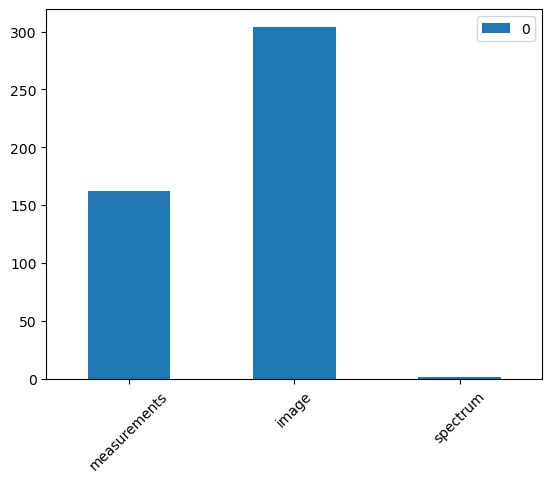

In [7]:
from collections import Counter
dp_types = res['dataproduct_type']
dp_types_counts = Counter(dp_types)
df = pandas.DataFrame.from_dict(dp_types_counts, orient='index')
df.plot(kind='bar', rot=45)

In [16]:
type(res[0])
methods = [attr for attr in dir(res[0]) if callable(getattr(res[0], attr)) and not attr.startswith('__')]
print(methods)
# res[0]
# for xx in res:
#     print(xx)

['_get_soda_resource', 'cachedataset', 'get', 'getbyucd', 'getbyutype', 'getdataformat', 'getdatalink', 'getdataobj', 'getdataset', 'getdataurl', 'items', 'keys', 'make_dataset_filename', 'processed', 'suggest_dataset_basename', 'suggest_extension', 'values']


In [25]:
methods = [attr for attr in dir(res) if callable(getattr(res, attr)) and not attr.startswith('__')]
print(methods)
# type(res)

['_findinfos', '_findresultsresource', '_findresultstable', '_findstatus', '_findstatusinfo', '_from_result_url', 'broadcast_samp', 'cursor', 'fieldname_with_ucd', 'fieldname_with_utype', 'from_result_url', 'get_adhocservice_by_id', 'get_adhocservice_by_ivoid', 'getcolumn', 'getdesc', 'getrecord', 'getvalue', 'iter_adhocservices', 'iter_datalinks', 'to_qtable', 'to_table']


In [28]:
df = res.to_table().to_pandas()
df_cut = df[df["dataproduct_type"] == "spectrum"]
df_cut

,abmaglim,access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_subtype,dataproduct_type,dp_id,em_max,...,s_xel1,s_xel2,snr,strehl,t_exptime,t_max,t_min,t_resolution,t_xel,target_name
380,NaN,13440,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo:/...,,2,,spectrum,ADP.2020-06-09T06:35:43.457,9.463940e-07,...,<NA>,<NA>,153.4,NaN,7199.997,56082.139775,56082.054678,7352.384256,<NA>,TOO_BulgeDwarf
415,NaN,6180,application/x-votable+xml;content=datalink,http://archive.eso.org/datalink/links?ID=ivo:/...,,2,,spectrum,ADP.2020-06-09T06:35:43.500,4.999730e-07,...,<NA>,<NA>,49.4,NaN,7200.004,56082.139785,56082.054790,7343.599104,<NA>,TOO_BulgeDwarf


In [33]:
df_cut["access_url"]

380    http://archive.eso.org/datalink/links?ID=ivo:/...
415    http://archive.eso.org/datalink/links?ID=ivo:/...
Name: access_url, dtype: object

In [35]:
df_cut.iloc[0]["access_url"]

'http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2020-06-09T06:35:43.457'

In [ ]:
# df["access_url"][0]

'http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160'

In [36]:
!curl -v "http://archive.eso.org/datalink/links?ID=ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160"

*   Trying 134.171.46.246:80...
* Connected to archive.eso.org (134.171.46.246) port 80 (#0)
> GET /datalink/links?ID=ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160 HTTP/1.1
> Host: archive.eso.org
> User-Agent: curl/8.1.1
> Accept: */*
> 
< HTTP/1.1 200 
< Date: Mon, 15 Sep 2025 01:17:47 GMT
< Server: ESO/DatalinkServer-1.0
< Vary: Origin,Access-Control-Request-Method,Access-Control-Request-Headers
< X-Content-Type-Options: nosniff
< X-XSS-Protection: 1; mode=block
< Cache-Control: no-cache, no-store, max-age=0, must-revalidate
< Pragma: no-cache
< Expires: 0
< X-Frame-Options: DENY
< Content-Type: application/x-votable+xml;content=datalink
< Content-Length: 4435
< 
<?xml version="1.0" encoding="utf-8"?>
<VOTABLE version="1.3" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.ivoa.net/xml/VOTable/v1.3">
  <RESOURCE type="results">
    <TABLE>
      <INFO name="QUERY_STATUS" value="OK" />
      <FIELD name="ID" datatype="char" ucd="meta.id;meta.main" arraysize="*" /

In [22]:
res[0].getdataobj()

<DALResultsTable length=4>
                     ID                      ...
                                             ...
                   object                    ...
-------------------------------------------- ...
ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160 ...
ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160 ...
ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160 ...
ivo://eso.org/ID?ADP.2014-11-12T16:17:25.160 ...